# ICSS Data analysis script

## README
A template to analyze ICSS data from output files to plot. The motivation is to perform reproducible research by standardizing the steps that are performed for data analysis and statistical inference. 

### OUTLINE:
0. Prerequisite: CSV files of ICSS data files generated using the script written by Steve Cabilio
1. Preprocessing
2. Prepping data
    1. Cleaning
    2. Annotating
    3. Overview
3. Plotting raw data
4. Normalizing data
5. Plotting normalized data

Author(s): Suman K. Guha

---

## 1. ICSS data preprocessing 
As a prerequisite of analysis is to convert the data MedPC generated data to Theta0, M50, and Max Rate, using Steve Cabilio's program. **Note:** We use the CSV program as it is an open format and easier to work with. 

A typical file generated by the analysis program looks like

    Source:,C:\ICSS\EC-IVSA\RF\SG13\20190117.XLS

    Data_File,Box,Subject,Group,Experiment,End Date,End Time,MPC,Comment
    C:\ICSS\EC-IVSA\RF\SG13\20190117.XLS,1,SG13,RF,EC-IVSA,2019-01-17,11:57:23,ICSS4_01,Generated by macro C:\MED-PC IV\Macro\2019_RF_ICSS+IVSA_G1-PM_1 1/17/2019 10:50:26 AM

    Pulse1w,uAmp1,Pulse1Pulse2,Pulse2w,uAmp2,StimDur,StimDelay,TimeOut,TrialDur,ITI,NumPrimes,InterPrime,PrimeDelay,FR
    100,0,100,100,170,500,0,0.5,50,10,5,500,5500,1

    ,Pass1,Pass2,Pass3,Pass4
    M50,72.22,78.28,58.25,74.78
    T0,37.61,50.42,49.50,63.00
    MaxR,275,177,241,212
    Slope,210.71,201.21,740.44,618.61

    ,Pass1,Pass2,Pass3,Pass4
    M50 Mean,72.22,78.28,58.25,74.78
    T0 Mean,37.61,50.42,49.50,63.00
    MaxR Mean,275.00,177.00,241.00,212.00
    Slope Mean,210.71,201.21,740.44,618.61

    ,Pass1,Pass2,Pass3,Pass4
    M50 %Baseline,100.00,108.39,80.65,103.54
    T0 %Baseline,100.00,134.08,131.62,167.52
    MaxR %Baseline,100.00,64.36,87.64,77.09
    Slope %Baseline,100.00,95.49,351.40,293.58

Once we run the preprocessing step it looks like

    Date,Subject,Experiment,Pass,T0,M50,MaxRate
    2019-01-17,SG13,RF,1,37.61,72.22,275
    2019-01-17,SG13,RF,2,50.42,78.28,177
    2019-01-17,SG13,RF,3,49.50,58.25,241
    2019-01-17,SG13,RF,4,63.00,74.78,212
    
In the next step we are going to batch process this conversion step by looping over all the files. For us to be able to do that, we need to have very rigid file structures. A typical file structure _**should**_ be
   
    Cohort01
    |
    |---Subject01
    |   |
    |   ANA_<YYYYMMDD>.CSV
    |
    |---Subject02
    |   |
        ANA_<YYYYMMDD>.CSV

For the preprocessing part, we extract the values of each animal, for each day. After that is performed we will combine and store them in a table format.

In [13]:
%%capture
%%bash
# 0. Preprocessing ANA files that are generated by Steve Cabilio's program
# this line makes the script machine agnostic by assigning the username automatically
userName=$(echo $USER)

# We move to the folder where the cohort data is stored
# cd </path/to/cohort/data>
cd /Users/$userName/Dropbox\ \(Partners\ HealthCare\)/Projects/R01_2017_OxycSA-NASh-Glutamate/_data_R01_2017/_data_R01_2017_ICSS/_ana_files/Cohort01

# entering each subject/animal directory to list all the CSV files and to run the program on each
for dirName in $(ls -d */)
do
    cd $dirName
    for fileName in $(ls ANA*.CSV)
    do
        preprocessICSSFiles --file $fileName;
    done
    cd ..
done

In [3]:
%load_ext rpy2.ipython

In [23]:
%%capture
%%R
# loading required libraries for R
library(tidyverse)
library(lubridate)

# 1. loading data: set the path to 
dataDir <- "~/Dropbox (Partners HealthCare)/Projects/R01_2017_OxycSA-NASh-Glutamate/_data_R01_2017/_data_R01_2017_ICSS/_ana_files/Cohort01/"
fileList <- list.files(path = dataDir, pattern = "preprocessed.csv", recursive = T)
## generating combined data table
data <- fileList %>% map(~ read_csv(file.path(dataDir, .))) %>% reduce(rbind)

In [24]:
%%R
data %>% print

# A tibble: 1,096 x 7
   Date       Subject Experiment  Pass T0    M50   MaxRate
   <date>     <chr>   <chr>      <int> <chr> <chr>   <int>
 1 2019-01-17 SG13    RF             1 37.61 72.22     275
 2 2019-01-17 SG13    RF             2 50.42 78.28     177
 3 2019-01-17 SG13    RF             3 49.5  58.25     241
 4 2019-01-17 SG13    RF             4 63    74.78     212
 5 2019-01-18 SG13    RF             1 33.77 55.55     201
 6 2019-01-18 SG13    RF             2 59.77 69.08     165
 7 2019-01-18 SG13    RF             3 62.66 77.56     168
 8 2019-01-18 SG13    RF             4 57.85 81.47     158
 9 2019-01-22 SG13    RF             1 38.03 46.48     282
10 2019-01-22 SG13    RF             2 33.38 52.09     340
# ... with 1,086 more rows


In [42]:
%%R
# 2. Prepping data
# 2.1. Cleaning data
# re-assigning data types to individual columns. This gets broken when there are missing values
# Ideal data types
# Date   | Subject  | Experiment |   Pass   |  T0   |  M50  | MaxRate
# <date> | <factor> |  <factor>  | <factor> | <num> | <num> |  <num>

data$Subject <- data$Subject %>% as.factor
data$Experiment <- data$Experiment %>% as.factor
data$Pass <- data$Pass %>% as.factor
data$T0 <- data$T0 %>% as.numeric
data$M50 <- data$M50 %>% as.numeric
data %>% print

# A tibble: 1,052 x 7
   Date       Subject Experiment Pass     T0   M50 MaxRate
   <date>     <fct>   <fct>      <fct> <dbl> <dbl>   <int>
 1 2019-01-17 SG13    RF         1      37.6  72.2     275
 2 2019-01-17 SG13    RF         2      50.4  78.3     177
 3 2019-01-17 SG13    RF         3      49.5  58.2     241
 4 2019-01-17 SG13    RF         4      63    74.8     212
 5 2019-01-18 SG13    RF         1      33.8  55.6     201
 6 2019-01-18 SG13    RF         2      59.8  69.1     165
 7 2019-01-18 SG13    RF         3      62.7  77.6     168
 8 2019-01-18 SG13    RF         4      57.8  81.5     158
 9 2019-01-22 SG13    RF         1      38.0  46.5     282
10 2019-01-22 SG13    RF         2      33.4  52.1     340
# ... with 1,042 more rows


In [43]:
%%R
# 2. Prepping data
# 2.2. Overview 
# Dates over which the experiment has run
data$Date %>% str()
data$Date %>% unique()

 Date[1:1052], format: "2019-01-17" "2019-01-17" "2019-01-17" "2019-01-17" "2019-01-18" ...
 [1] "2019-01-17" "2019-01-18" "2019-01-22" "2019-01-23" "2019-01-24"
 [6] "2019-01-25" "2019-01-28" "2019-01-29" "2019-01-30" "2019-02-01"
[11] "2019-02-04" "2019-02-06" "2019-02-07" "2019-02-08" "2019-02-18"
[16] "2019-02-19" "2019-02-20" "2019-02-21" "2019-02-22" "2019-02-25"
[21] "2019-02-26" "2019-02-27" "2019-02-28" "2019-03-01" "2019-03-04"
[26] "2019-03-05" "2019-03-06" "2019-03-07" "2019-03-08" "2019-03-11"
[31] "2019-03-12" "2019-03-13" "2019-03-14" "2019-03-15" "2019-03-18"
[36] "2019-03-19" "2019-03-20" "2019-03-21" "2019-03-22" "2019-03-25"
[41] "2019-03-26" "2019-03-27" "2019-03-28" "2019-03-29" "2019-04-01"
[46] "2019-04-02" "2019-01-31"


In [44]:
%%R
# 2.2. Checking out data
# Subjects in the experiment over which the experiment has run
data$Subject %>% str()
data$Subject %>% unique()

 Factor w/ 7 levels "SG13","SG14",..: 1 1 1 1 1 1 1 1 1 1 ...
[1] SG13 SG14 SG15 SG17 SG20 SG24
Levels: SG13 SG14 SG15 SG17 SG19 SG20 SG24


In [88]:
%%R
# 2.1. Cleaning data
# SG19 is being discarded from the data as the rat did not move to the self-administration stage
# SG13 presumably had some infections
data <- data %>% filter(Subject != "SG19" & Subject != "SG13")

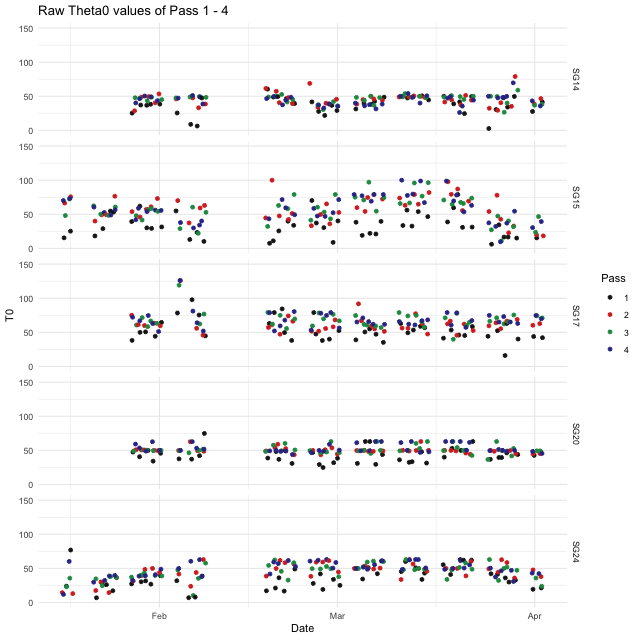

In [95]:
%%R -w 640 -h 640
# 3. Plotting raw values for T0, Pass 1 - 4
lower_limit = 0
upper_limit = 150
data %>% ggplot(aes(x = Date, y = T0)) + 
geom_jitter(aes(color = Pass)) + scale_color_manual(values = c("#1a1a1a", "#d73027", "#1a9850", "#313695")) +
ylim(lower_limit, upper_limit) + 
facet_grid(rows = vars(Subject)) + ggtitle("Raw Theta0 values of Pass 1 - 4") + theme_minimal()

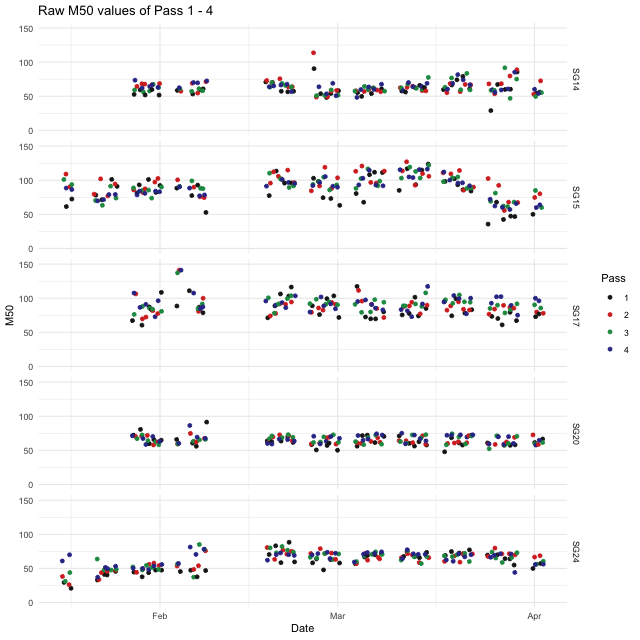

In [96]:
%%R -w 640 -h 640
# 3. Plotting raw values for M50, Pass 1 - 4
lower_limit = 0
upper_limit = 150
data %>% ggplot(aes(x = Date, y = M50)) + 
geom_jitter(aes(color = Pass)) + scale_color_manual(values = c("#1a1a1a", "#d73027", "#1a9850", "#313695")) +
ylim(lower_limit, upper_limit) +
facet_grid(rows = vars(Subject)) + ggtitle("Raw M50 values of Pass 1 - 4") + theme_minimal()

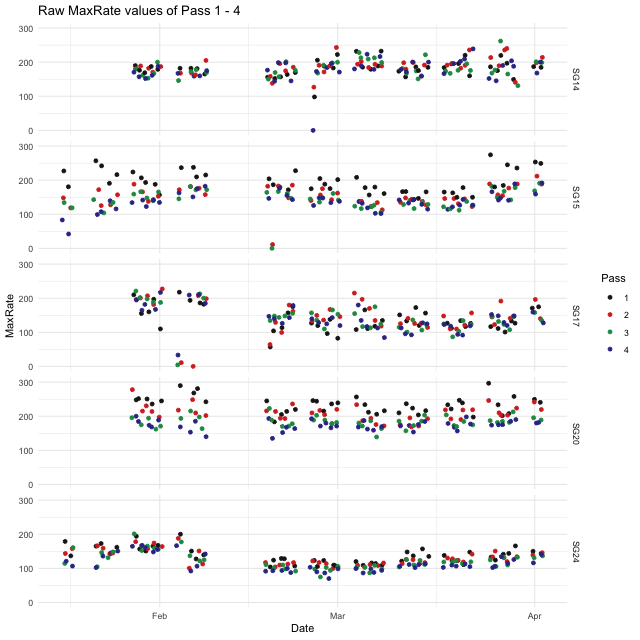

In [97]:
%%R -w 640 -h 640
# 3. Plotting raw values for MaxRate, Pass 1 - 4
lower_limit = 0
upper_limit = 300
data %>% ggplot(aes(x = Date, y = MaxRate)) + 
geom_jitter(aes(color = Pass)) + scale_color_manual(values = c("#1a1a1a", "#d73027", "#1a9850", "#313695")) +
ylim(lower_limit, upper_limit) +
facet_grid(rows = vars(Subject)) + ggtitle("Raw MaxRate values of Pass 1 - 4") + theme_minimal()

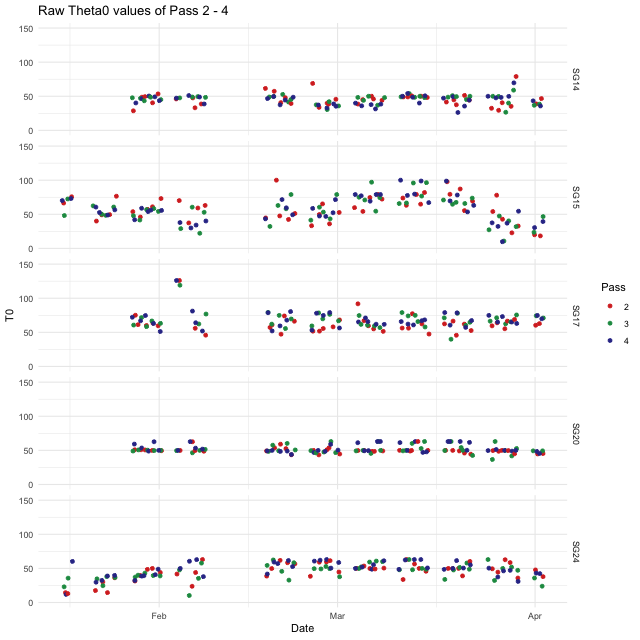

In [98]:
%%R -w 640 -h 640
# 3. Plotting raw values for T0, Pass 2 - 4
lower_limit = 0
upper_limit = 150
data %>% filter(Pass != 1) %>% ggplot(aes(x = Date, y = T0)) + 
geom_jitter(aes(color = Pass)) + scale_color_manual(values = c("#d73027", "#1a9850", "#313695")) +
ylim(lower_limit, upper_limit) +
facet_grid(rows = vars(Subject)) + ggtitle("Raw Theta0 values of Pass 2 - 4") + theme_minimal()

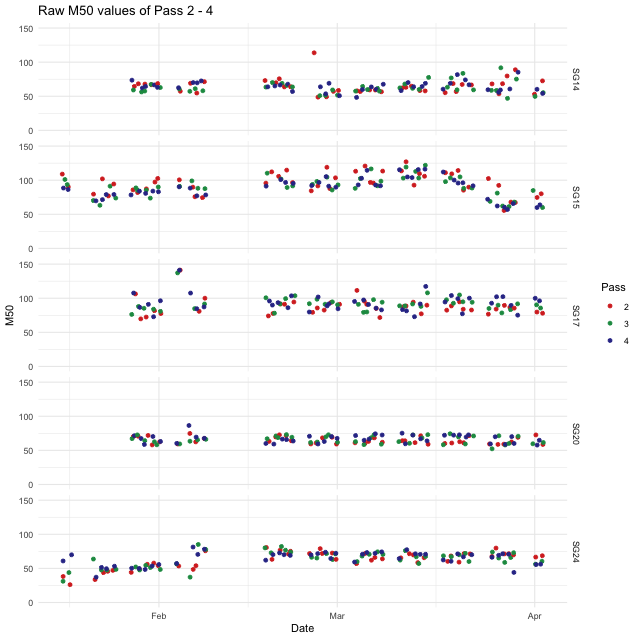

In [99]:
%%R -w 640 -h 640
# 3. Plotting raw values for M50, Pass 2 - 4
lower_limit = 0
upper_limit = 150
data %>% filter(Pass != 1) %>% ggplot(aes(x = Date, y = M50)) + 
geom_jitter(aes(color = Pass)) + scale_color_manual(values = c("#d73027", "#1a9850", "#313695")) +
ylim(lower_limit, upper_limit) +
facet_grid(rows = vars(Subject)) + ggtitle("Raw M50 values of Pass 2 - 4") + theme_minimal()

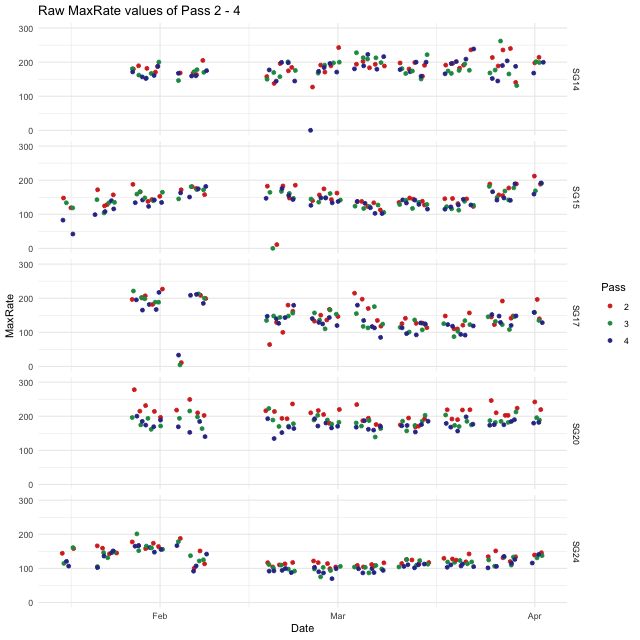

In [100]:
%%R -w 640 -h 640
# 3. Plotting raw values for MaxRate, Pass 2 - 4
lower_limit = 0
upper_limit = 300
data %>% filter(Pass != 1) %>% ggplot(aes(x = Date, y = MaxRate)) + 
geom_jitter(aes(color = Pass)) + scale_color_manual(values = c("#d73027", "#1a9850", "#313695")) +
ylim(lower_limit, upper_limit) +
facet_grid(rows = vars(Subject)) + ggtitle("Raw MaxRate values of Pass 2 - 4") + theme_minimal()

In [79]:
%%R
# 3. Normalizing data
# Normalizing data to 2 days pre- and post-surgery
# Normalizing dates 
# Pre-surgery: 2019-02-07, 2019-02-08
# Post-surgery: 2019-02-18, 2019-02-19
dataSG13 <- data %>% filter(Subject == "SG13")
dataSG14 <- data %>% filter(Subject == "SG14")
dataSG15 <- data %>% filter(Subject == "SG15")
dataSG17 <- data %>% filter(Subject == "SG17")
dataSG20 <- data %>% filter(Subject == "SG20")
dataSG24 <- data %>% filter(Subject == "SG24")

dataSG13 %>% filter(Date >= "2019-02-07" & Date <= "2019-02-19") %>% print

# A tibble: 16 x 7
   Date       Subject Experiment Pass     T0   M50 MaxRate
   <date>     <fct>   <fct>      <fct> <dbl> <dbl>   <int>
 1 2019-02-07 SG13    RF         1      51.6  81.9     229
 2 2019-02-07 SG13    RF         2      50    60.1     194
 3 2019-02-07 SG13    RF         3      63    71.0     199
 4 2019-02-07 SG13    RF         4      63    74.8     183
 5 2019-02-08 SG13    RF         1      28.8  70.5     237
 6 2019-02-08 SG13    RF         2      61.1  71.8     190
 7 2019-02-08 SG13    RF         3      62.0  70.4     171
 8 2019-02-08 SG13    RF         4      26.2 104.      171
 9 2019-02-18 SG13    RF         1      31.1  57.1     203
10 2019-02-18 SG13    RF         2      33.7  66.3     163
11 2019-02-18 SG13    RF         3      52.0  82.5     140
12 2019-02-18 SG13    RF         4      78.3  88.5     144
13 2019-02-19 SG13    RF         1      41.5  80.1     213
14 2019-02-19 SG13    RF         2      50    58.2     162
15 2019-02-19 SG13    RF         3   